Data extracted


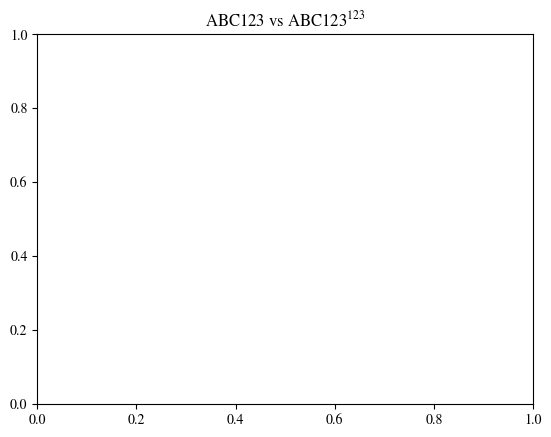

In [4]:
import numpy as np
from helpers import *
from implementations import *
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

x_train,x_test,y_train,train_ids,test_ids = load_csv_data("dataset",sub_sample=False)#Extract Data
print("Data extracted")

In [6]:
####################
#Pre-processing data
####################
N=x_train.shape[0]

##Removing NANs
nans = np.zeros(x_train.shape)
nans[np.isnan(x_train)]=1
nans_occurence=np.sum(nans,axis=0) #Number of nans by feature
good_features = (nans_occurence < N*0.3) #Keep only features with less than 30% of Nans

##Removing constant features and standardizing data
std_per_feature = np.nanstd(x_train,axis=0)
good_features = np.logical_and(good_features , std_per_feature!=0)
x_tr,mean_per_feature,std_per_feature = standardize(x_train[:,good_features])
x_te = x_test[:,good_features]
x_te -=mean_per_feature
x_te /=std_per_feature
np.nan_to_num(x_tr,copy=False,nan=0) #Replace Nans with 0
np.nan_to_num(x_te,copy=False,nan=0) #Same
#Adjustments
y_train[y_train==-1]=0 # The logistic loss function is implemented for y equal to 1 and 0 not 1 and -1
x_tr=np.insert(x_tr,0,1,axis=1)# Add a constant feature
x_te=np.insert(x_te,0,1,axis=1)#Add a constant feature
print("Data pre-processed")

Data pre-processed


In [8]:
#############################################
# Testing different regularizations parameters
############################################
k_folds=5 #Number of blocs
D=x_tr.shape[1]#Number of features
initial_w=np.ones(D)#Initial weights
gamma=0.01
max_iters=200
batch_size=64
##################
# Lambda variation
##################
lambdas=np.logspace(-1,0.3,30)#Try differents lambdas
#lambdas=np.arange(0.8,1.5,0.05)
accuracies=[]#Validation accuracies for different lambdas
losses_tr=[] #Validation losses for different lambdas
losses_val=[]
F1s=[]


k_indices = build_k_indices(y_train,k_folds,np.random.seed())# Separate training data in blocs
for lambda_ in lambdas:
    
    mean_acc=0
    mean_tr_loss =0
    mean_F1=0
    mean_val_loss=0
    ## Work on each k-bloc
    for k in np.arange(k_folds):
        k_validate = k_indices[k]
        x_validate=x_tr[k_validate,:] #Use the k-th bloc to validate
        k_train = np.delete(k_indices,k,axis=0).flatten() #Indices of the training blocs
        w,loss_tr= reg_logistic_regression_stoch(y_train[k_train],x_tr[k_train],lambda_,initial_w,max_iters,gamma,batch_size)#Regularized logistic regression
        loss_val = calculate_NLL_loss(y_train[k_validate],x_validate,w)
        mean_val_loss+=loss_val
        mean_tr_loss+=loss_tr
        prob = sigmoid(x_validate.dot(w))
        mean_acc+= accuracy(prob,y_train[k_validate])  
        mean_F1+= F1(prob ,y_train[k_validate])
    mean_acc/=k_folds
    mean_tr_loss/=k_folds
    mean_F1/=k_folds
    mean_val_loss/=k_folds
    print("Computed lambda : {}".format(lambda_))
    losses_val.append(mean_val_loss)
    F1s.append(mean_F1)
    accuracies.append(mean_acc)
    losses_tr.append(mean_tr_loss) 


Computed lambda : 0.8
Computed lambda : 0.8500000000000001
Computed lambda : 0.9000000000000001
Computed lambda : 0.9500000000000002
Computed lambda : 1.0000000000000002
Computed lambda : 1.0500000000000003
Computed lambda : 1.1000000000000003
Computed lambda : 1.1500000000000004
Computed lambda : 1.2000000000000004
Computed lambda : 1.2500000000000004
Computed lambda : 1.3000000000000005
Computed lambda : 1.3500000000000005
Computed lambda : 1.4000000000000006
Computed lambda : 1.4500000000000006


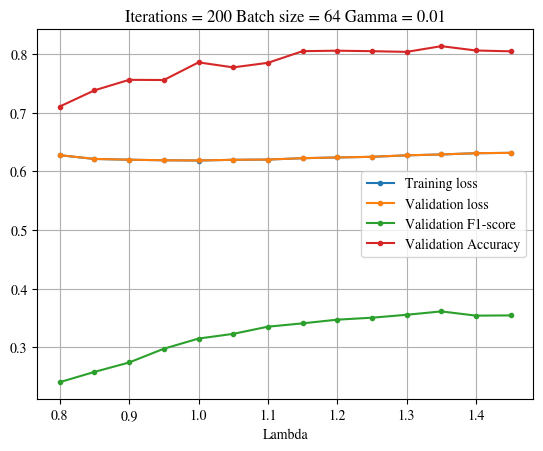

Max F1 = 0.3610324770105619 at Lambda = 1.3500000000000005
(328135, 145)


In [9]:
plt.plot(lambdas,losses_tr,label='Training loss',marker='.')
plt.plot(lambdas,losses_val,label='Validation loss',marker='.')
plt.plot(lambdas,F1s,label='Validation F1-score',marker='.')
plt.plot(lambdas,accuracies,label='Validation Accuracy',marker='.')
#plt.semilogx(lambdas,losses_tr,label='Training loss',marker='.')
#plt.semilogx(lambdas,losses_val,label='Validation loss',marker='.')
#plt.semilogx(lambdas,F1s,label='Validation F1-score',marker='.')
#plt.semilogx(lambdas,accuracies,label='Validation Accuracy',marker='.')
plt.xlabel('Lambda')
plt.legend()
plt.grid(True)
plt.title("Iterations = {} Batch size = {} Gamma = {}".format(max_iters,batch_size,gamma))
plt.show()

print("Max F1 = {} at Lambda = {}".format(max(F1s),lambdas[np.argmax(F1s)]) )
print(x_tr.shape)

In [22]:
###############################
##Iteration convergence analysis
################################
lambda_=1.320351779716295
max_iters = 10
gamma=0.01
k_folds=5 #Number of blocs
D=x_tr.shape[1]#Number of features
initial_w=np.ones(D)#Initial weights
k_indices = build_k_indices(y_train,k_folds,np.random.seed())# Separate training data in blocs

mean_tr_losses=np.zeros(max_iters)
mean_val_losses=np.zeros(max_iters)
mean_F1s=np.zeros(max_iters)
mean_acc=np.zeros(max_iters)
for k in range(k_folds):
    tr_losses=[]#Training loss for each iteration
    val_losses=[]#Validation loss for each iteration
    F1s=[]#F1 per iteration
    accuracies=[]#accuracy per iteration
    k_validate = k_indices[k]
    x_validate=x_tr[k_validate,:] #Use the k-th bloc to validate
    k_train = np.delete(k_indices,k,axis=0).flatten() #Indices of the training blocs
    w=initial_w
    for i in range(max_iters):
        w,loss_tr=reg_logistic_regression_stoch(y_train[k_train],x_tr[k_train],lambda_,w,50,gamma,batch_size)
        tr_losses.append(loss_tr)
        val_losses.append(calculate_NLL_loss(y_train[k_validate],x_validate,w))
        prob=sigmoid(x_validate.dot(w))
        F1s.append(F1(prob ,y_train[k_validate]))
        accuracies.append(accuracy(prob,y_train[k_validate]))
    mean_tr_losses += tr_losses
    mean_val_losses += val_losses
    mean_F1s += F1s
    mean_acc += accuracies
    print("K-fold = {}".format(k))
mean_tr_losses /=k_folds
mean_val_losses /=k_folds
mean_F1s /= k_folds
mean_acc/=k_folds


K-fold = 0
K-fold = 1
K-fold = 2
K-fold = 3
K-fold = 4


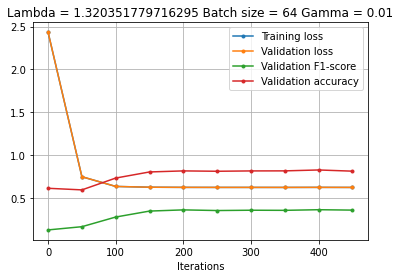

In [23]:
iter_ix=np.arange(max_iters)
plt.plot(iter_ix*50,mean_tr_losses[iter_ix],label='Training loss',marker='.')
plt.plot(iter_ix*50,mean_val_losses[iter_ix],label='Validation loss',marker='.')
plt.plot(iter_ix*50,mean_F1s[iter_ix],label='Validation F1-score',marker='.')
plt.plot(iter_ix*50,mean_acc[iter_ix],label='Validation accuracy',marker='.')
plt.xlabel('Iterations')
plt.grid(True)
plt.title('Lambda = {} Batch size = {} Gamma = {}'.format(lambda_,batch_size,gamma))
plt.legend()
plt.show()

In [26]:
##################
## Create test results
##################
D=x_tr.shape[1]#Number of features
initial_w=np.ones(D)
w,loss = reg_logistic_regression_stoch(y_train,x_tr,1.320351779716295,initial_w,200,0.01,64)
print(loss)

0.6279287432366256


In [27]:
prob = sigmoid(x_te.dot(w))
y_test=np.zeros(x_te.shape[0])
y_test[prob >=0.5]=1
y_test[prob <0.5]=-1
create_csv_submission(test_ids,y_test,"ehouais.csv")